## Can you guess the intrument by the sound?
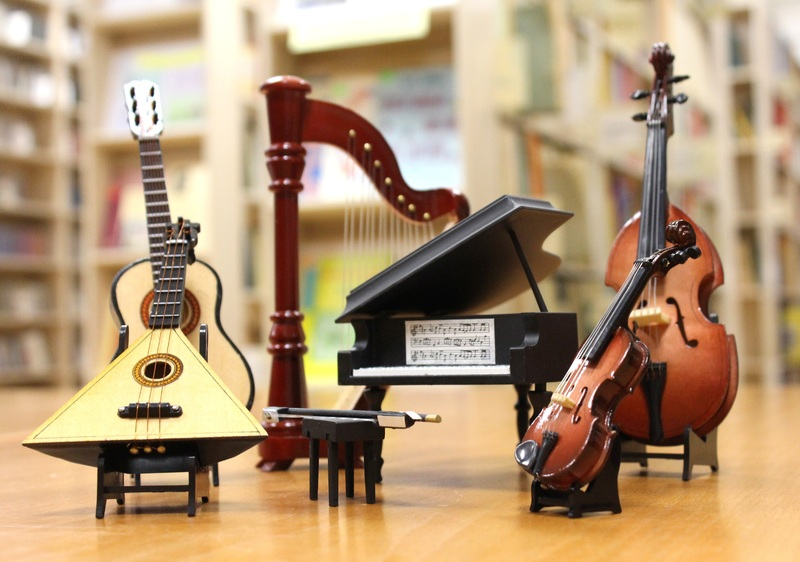

#### Well, Not anymore! In the world of AI we have computers to do so.  Atleast, Fourty One of those covered here!
-----

As usual lets start by importing some commonly used libraries of python.

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
%matplotlib inline

### We'll need the Audio files to train our PC along with the labels

Thanks to Freesound, Creative Commons and Google's AudioSet Ontology.

In [11]:
# Using Pandas we'll load the csv files
train = pd.read_csv('train.csv')
test = pd.read_csv('test_post_competition.csv')
test = test[test['label']!= 'None'].head(50)                                   #using only rows with available label
test = test.reset_index(drop = True)
test.drop(['usage', 'freesound_id', 'license'], axis = 1, inplace =True)

#### Lets have a look of first 8 rows of our Dataset.

In [12]:
train.head(8)

fname               label  manually_verified
0  00044347.wav              Hi-hat                  0
1  001ca53d.wav           Saxophone                  1
2  002d256b.wav             Trumpet                  0
3  0033e230.wav        Glockenspiel                  1
4  00353774.wav               Cello                  1
5  003b91e8.wav               Cello                  0
6  003da8e5.wav               Knock                  1
7  0048fd00.wav  Gunshot_or_gunfire                  1

In [13]:
test.head(8)

fname           label
0  00326aa9.wav            Oboe
1  0038a046.wav       Bass_drum
2  007759c4.wav       Saxophone
3  008afd93.wav       Saxophone
4  00ae03f6.wav           Chime
5  00eac343.wav  Electric_piano
6  010a0b3a.wav         Shatter
7  01a5a2a3.wav            Bark

In [14]:
print("total number of training observation are", len(train))     #### No. of observations to train the model
print("total no of labels are", train['label'].nunique())         #### No. of categories to train our model for

total number of training observation are 9473
total no of labels are 41


----
## Exploratory Data Analysis 
    1. Enumarate and Distribuion of Categories
    2. Loading and reading the Audio Files
    3. Extracting meta_data of audio Files
    4. Interactive Plots and more..

#### 1. Lets give a number to each category using Sexy enumerate built-in function in python

In [15]:
LABELS = list(train.label.unique())
label_idx = {label: i for i, label in enumerate(LABELS)}
train["label_idx"] = train['label'].apply(lambda x: label_idx[x])
train[['fname', 'label', 'label_idx']].head(8)

fname               label  label_idx
0  00044347.wav              Hi-hat          0
1  001ca53d.wav           Saxophone          1
2  002d256b.wav             Trumpet          2
3  0033e230.wav        Glockenspiel          3
4  00353774.wav               Cello          4
5  003b91e8.wav               Cello          4
6  003da8e5.wav               Knock          5
7  0048fd00.wav  Gunshot_or_gunfire          6

---
##### Lets Plot Count of Observations per Categories
Hover around your mouse pointer to see the plot more coherently

In [16]:
from plotly.offline import iplot
import cufflinks as cf
cf.go_offline()

train.groupby('label').size().sort_values(ascending = False).iplot(kind = 'bar', )

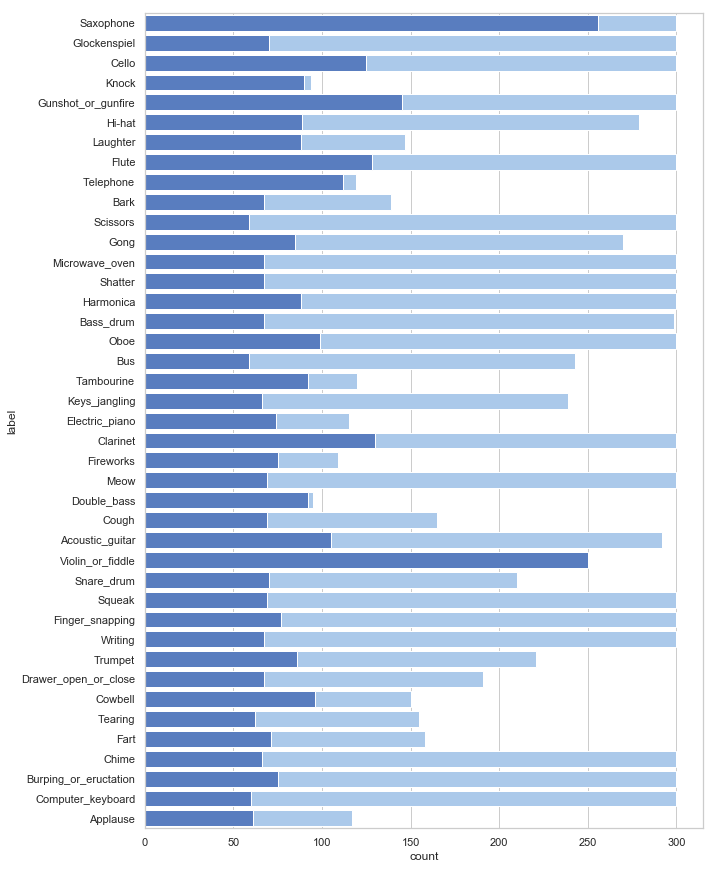

In [17]:
import seaborn as sns

sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(10, 15))

sns.set_color_codes("pastel")
sns.countplot(y ='label', data = train,
            label="Total", color="b")

sns.set_color_codes("muted")
sns.countplot(y = 'label', data = train[train['manually_verified']==1], 
             label = "Manually Verified", color = "b")

#### 2. Time to load Audio Files

In [18]:
#To be able to play sound on the notebook
import IPython.display as ipd

fname = 'audio_train/audio_train/00cb787c.wav' 
second_sample = 'audio_train/audio_train/001ca53d.wav'

ipd.Audio(second_sample)

In [19]:
ipd.Audio(fname)

In [20]:
from scipy.io import wavfile
rate, data = wavfile.read(fname)

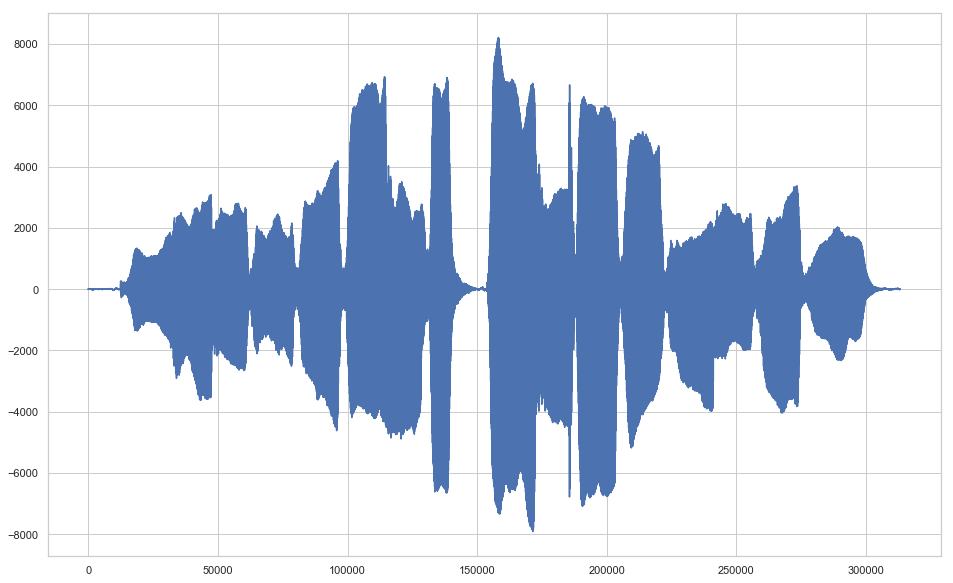

In [21]:
plt.figure(figsize = (16,10))
plt.plot(data)

#### Lets Zoom in a bit to observe our sound file closely

([<matplotlib.lines.Line2D at 0x282653dcb38>],
 [<matplotlib.lines.Line2D at 0x282653e6198>])

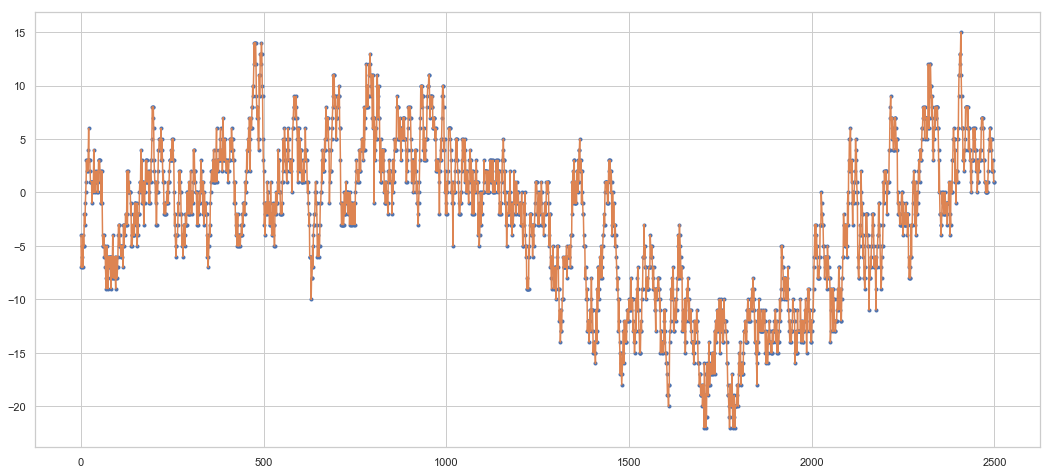

In [22]:
plt.figure(figsize=(18, 8))
plt.plot(data[:2500], '.' ), plt.plot(data[:2500], '-')

#### Extract number of frames in each audio file and Total Duration

In [23]:
import wave
def extract_file_metadata(row):
    file_name = 'audio_train/audio_train/'+ row['fname']
    wav = wave.open(file_name)
    return wav.getnframes()

In [24]:
train['no_of_frames'] = train.apply(extract_file_metadata, axis = 1)
train['duration_seconds'] = train['no_of_frames']/(44100)

#### Lets have a final look at our train dataset

In [25]:
train.head(10)

fname               label  manually_verified  label_idx  \
0  00044347.wav              Hi-hat                  0          0   
1  001ca53d.wav           Saxophone                  1          1   
2  002d256b.wav             Trumpet                  0          2   
3  0033e230.wav        Glockenspiel                  1          3   
4  00353774.wav               Cello                  1          4   
5  003b91e8.wav               Cello                  0          4   
6  003da8e5.wav               Knock                  1          5   
7  0048fd00.wav  Gunshot_or_gunfire                  1          6   
8  004ad66f.wav            Clarinet                  0          7   
9  0063ab88.wav   Computer_keyboard                  0          8   

   no_of_frames  duration_seconds  
0        617400             14.00  
1        455112             10.32  
2         19404              0.44  
3        352800              8.00  
4        199332              4.52  
5        585648             13.28  
6         59976              1.36  
7         45864              1.04  
8        308700              7.00  
9       1307124             29.64

#### Lets see Average lenght of Audio Files per category

In [26]:
train[['label', 'duration_seconds']].groupby('label').median().iplot(kind = 'bar', color = 'green')

---
#### In Order to build a Machine learning Model, We'll have to convert Audio File into Numbers. Enabling us to use our linear algebra knowledge

We observe that:
1. The number of audio samples per category is **non-nform**. The minimum number of audio samples in a category is `94` while the maximum is `300`
2. Also, the proportion of `maually_verified` labels per category is non-uniform.
<a id="audio_files"></a>
### Reading Audio Files

The audios are [Pulse-code modulated](https://en.wikipedia.org/wiki/Audio_bit_depth) with a [bit depth](https://en.wikipedia.org/wiki/Audio_bit_depth) of 16 and a [sampling rate](https://en.wikipedia.org/wiki/Sampling_%28signal_processing%29) of 44.1 kHz

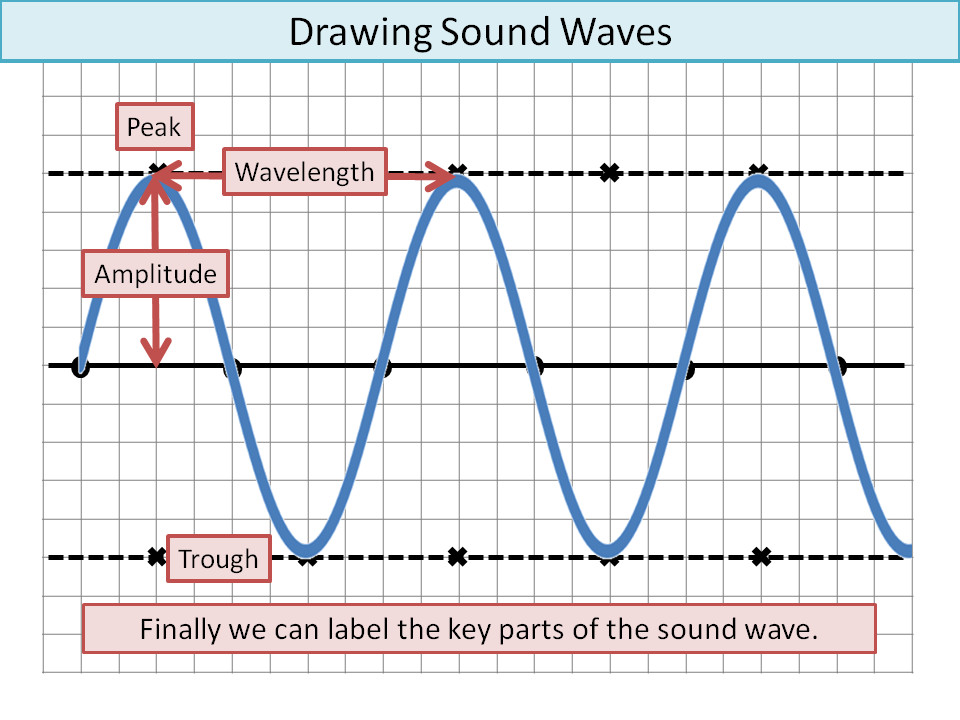

* **Bit-depth = 16**: The amplitude of each sample in the audio is one of 2^16 (=65536) possible values. 
* **Samplig rate = 44.1 kHz**: Each second in the audio consists of 44100 samples. So, if the duration of the audio file is 3.2 seconds, the audio will consist of 44100\*3.2 = 141120 values

In [32]:
sample_rate = 44100
import librosa
X, _ =  librosa.core.load(fname, res_type = 'kaiser_fast', sr = sample_rate)
X.shape,

((313110,),)

#### Librosa library gives us normalised values in form of a single column matrix 

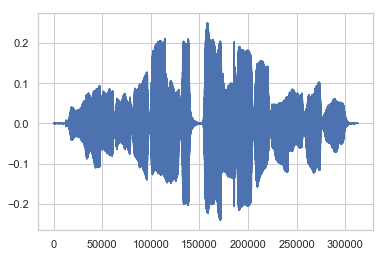

In [33]:
plt.plot(X)

In [34]:
X_sample = X[0:3*44100]
X_sample

array([-0.00012207, -0.00021362, -0.00018311, ..., -0.09637451,
       -0.09622192, -0.09539795], dtype=float32)

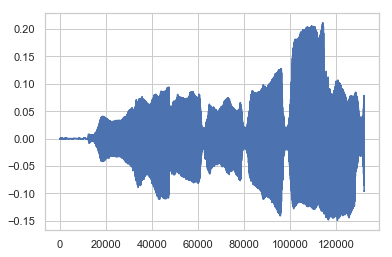

In [35]:
plt.plot(X_sample)

In [36]:
mfccs =librosa.feature.mfcc(y = X_sample, sr = sample_rate, n_mfcc = 40).T
mfccs.shape

(259, 40)

------

## Defining the parameters to train the model
### Machine learning part begins

#### Create a class to store values of the arguments which can be used in all the different models by just creating an instance

In [37]:

class Config(object):
    def __init__(self,
                 sampling_rate=16000, audio_duration=3, n_classes=41,
                 use_mfcc=False, n_folds=10, learning_rate=0.0001, 
                 max_epochs=50, n_mfcc=20):
        
        self.sampling_rate = sampling_rate                          # Sampling rate is frames per seconds
        self.audio_duration = audio_duration                        # Audio duration for which we wan't to train our model
        self.n_classes = n_classes                                  # Number of categories in our classification 
        self.use_mfcc = use_mfcc                                    # whethe use mfcc transformation or Nueral Net on raw data 
        self.n_mfcc = n_mfcc                                        # Number of columns you want to transform sound into
        self.n_folds = n_folds                                      # parameter defined in Convolution 2d
        self.learning_rate = learning_rate                          # lower the learning rate more precise training
        self.max_epochs = max_epochs                                # Number of epochs to try to decrease loss function

        self.audio_length = self.sampling_rate * self.audio_duration
                                                                    # length of data points for the model 
        if self.use_mfcc:
            self.dim = (self.n_mfcc, 1 + int(np.floor(self.audio_length/512)), 1)
        else:
            self.dim = (self.audio_length, 1)

## Create an instance of class Config we just defined for our MFCC model

In [38]:
config = Config(sampling_rate = 44100, audio_duration =3, n_folds = 10, learning_rate = 0.0001, use_mfcc =True, n_mfcc =40)

### What if the audio file is smaller than the audio_duration of 3 seconds??
---
#### We'll use numpy to do padding for us. 
    1. Offsetting the small audio data and fill zeros on either side of the array. 
    2. Triming the big audio file to fit audio_duration of 3 seconds
    
---
Here We'll first import each audio file using for loop. Within each for loop we'll extract the features of each audio file using python's mfcc library. 
In layman's term we're gonna convert every audio file in numbers and store them in matrix. 

In [39]:
import librosa
def prepare_data(df, config, data_dir):
    X= np.empty(shape= (df.shape[0], config.dim[0], config.dim[1], 1))
    set_length = config.audio_length                                    # set_lenght = 3 seconds, set in the Config() instance.
    
    for i , fname in enumerate(df['fname']):                            # create a file path using string operation.
        file_path = data_dir + str(fname)                               # use file path as an argument in the load command below.
        data, _ = librosa.core.load(file_path, 
                                    sr = config.sampling_rate, 
                                    res_type = "kaiser_fast")
    
        if len(data) > set_length:                                      # Compare the lenght of audio file to our required length
            data = data[:set_length]                                    # if length of audio file > 3 sec, trim audio to 3 sec.
        
        else:
            if set_length > len(data):                                  # if length of audio is less than 3 second.
                max_offset = set_length - len(data)                     # Store the difference in variable max_offset.
                offset = np.random.randint(max_offset)                  # pick a random number between 0 to max_offset, 
                                                                        # store it as offset
            else:
                offset = 0
            
            data = np.pad(data,                                         # np.pad (used for filling up arrays where values are missing) 
                          pad_width = (offset, set_length - len(data) - offset), # Number of values padded to the edges of each axis.(before, after)
                          mode = "constant")                            # mode= constant, where default is zero. 
    
        data = librosa.feature.mfcc(data,                               # Extract features of our 1-D array, converts in 2-D array.
                                    sr=config.sampling_rate,
                                    n_mfcc=config.n_mfcc)               # config.n_mfcc = 40 so we will get 41 column
        
        data = np.expand_dims(data, axis =-1)                           # store our features with the original train data with labels.
        X[i,] = data
    
    return X

### Prepare Audio Files to be used for ML model 
Using the function prepare_data convert all train and test audio files in usable form.

In [40]:
X_train = prepare_data(train,config, 'audio_train/audio_train/')
X_test = prepare_data(test, config, 'audio_test/audio_test/')

In [41]:
print(X_train.shape)
print(X_test.shape)

(9473, 40, 259, 1)
(50, 40, 259, 1)


Normalisation is an important step #Don't miss this step before you start training your model

In [42]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

In [43]:
# import cPickle

# # write to cPickle
# cPickle.dump( X_train, open( "X_train.pkl", "wb" ))
# cPickle.dump( X_test, open( "X_test.pkl", "wb" ))
# # read from cPickle
# #thing_to_save = cPickle.load( open( "filename.pkl", "rb" ) )

## Build the Machine Learning model 
Lets first import important libraries 
We'll use Keras build on top of TensorFlow by Google

Machine Learning model we're going to use here is Convolution2D

In [44]:
# import cPickle
# X_train = cPickle.load(open("X_train.pkl", "rb"))

In [45]:
from keras import losses, models, optimizers
from keras.activations import relu, softmax

from keras.layers import (Convolution1D, Dense, Dropout, GlobalAveragePooling1D, 
                          GlobalMaxPool1D, Input, MaxPool1D, concatenate)
from keras.utils import Sequence, to_categorical

Using TensorFlow backend.


In [46]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
gpu_config = tf.ConfigProto()
gpu_config.gpu_options.allow_growth = True
#config.gpu_options.per_process_gpu_memory_fraction = 0.9
set_session(tf.Session(config= gpu_config))

In [47]:
from keras.layers import (Convolution2D, GlobalAveragePooling2D, BatchNormalization, Flatten,
                          GlobalMaxPool2D, MaxPool2D, concatenate, Activation)


In [48]:
def get_2d_conv_model(config):
    
    nclass = config.n_classes                                    # Number of predictive categories in the model
    
    inp = Input(shape=(config.dim[0],config.dim[1],1))           # Define shape of the matrices for the input
    x = Convolution2D(32, (4,10), padding="same")(inp)           # Machine learning model
    x = BatchNormalization()(x) 
    x = Activation("relu")(x)                                    # Using Relu as activation function 
    x = MaxPool2D()(x)
        
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)

    x = Flatten()(x)
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

In [49]:
from keras import backend as K
from keras.callbacks import (EarlyStopping, LearningRateScheduler, ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras.utils import Sequence, to_categorical

from sklearn.model_selection import KFold, train_test_split
import shutil
import os

## creating directory to save our Model Predictions


In [50]:

PREDICTION_FOLDER = 'predictions_2d_conv'                               
if not os.path.exists(PREDICTION_FOLDER):
    os.mkdir(PREDICTION_FOLDER)
if os.path.exists('logs/' + PREDICTION_FOLDER):
    shutil.rmtree('logs/' + PREDICTION_FOLDER)


## Running the model on the Train Set
#### Some Important things to note. 
    1. We'll split our train data in two parts 
        a. X_train, y_train for training which would be 90% of total train data
        b. X_val, y_val to validate our trained model within the neural net training
    
    2. To have better visiblity of how is our Model doing we use Keras library functions. 
        a. ModelCheckpoint
        b. EarlyStopping (to jump to next Fold is no more imporvement in the loss function)
        c. TensorBoard to have our model saved in form of graph function for easy retrieval. 
    
    3. We run model for 8 times with different training and validation set.

In [ ]:
kf = KFold(n_splits = 8)
y_train = to_categorical(train['label_idx'])
for i , (train_split, val_split) in enumerate(kf.split(X_train, y_train)):
    
    K.clear_session()
    
    X, y, X_val, y_val = X_train[train_split], y_train[train_split], X_train[val_split], y_train[val_split]
    
    checkpoint = ModelCheckpoint('best_w_%d.h5'%(i+2), monitor='val_loss', verbose=1, save_best_only=True)
    early = EarlyStopping(monitor="val_loss", mode="min", patience= 4)
    tb = TensorBoard(log_dir='./logs/' + PREDICTION_FOLDER + '/fold_new_%i'%(i+2), write_graph=True)
    callbacks_list = [checkpoint, early, tb]
    print ("Fold:", str(i) +' out of 10 is running')
    print ("\n-------------------------------------------------------------------------------")
    
    
    model = get_2d_conv_model(config)
    history = model.fit(X, y, 
                        validation_data=(X_val, y_val), 
                        callbacks=callbacks_list, 
                        batch_size=64, 
                        epochs=config.max_epochs)
    model.load_weights('best_w_%d.h5'%(i+2))    
    
    
    # Save train predictions
    predictions = model.predict(X_train, batch_size=64, verbose=1)
    np.save(PREDICTION_FOLDER + "/train_predictions_%d.npy"%(i+2), predictions)
    
    # Save test predictions
    predictions = model.predict(X_test, batch_size=64, verbose=1)
    np.save(PREDICTION_FOLDER + "/test_predictions_%d.npy"%(i+2), predictions)

Fold: 0 out of 10 is running

-------------------------------------------------------------------------------
Train on 8288 samples, validate on 1185 samples
Epoch 1/50
8288/8288 [==============================] - 16s 2ms/step - loss: 3.3835 - acc: 0.1425 - val_loss: 3.1670 - val_acc: 0.2034

Epoch 00001: val_loss improved from inf to 3.16699, saving model to best_w_2.h5
Epoch 2/50
8288/8288 [==============================] - 14s 2ms/step - loss: 2.9481 - acc: 0.2609 - val_loss: 2.9759 - val_acc: 0.2565

Epoch 00002: val_loss improved from 3.16699 to 2.97594, saving model to best_w_2.h5
Epoch 3/50
8288/8288 [==============================] - 14s 2ms/step - loss: 2.7168 - acc: 0.3329 - val_loss: 2.7812 - val_acc: 0.3215

Epoch 00003: val_loss improved from 2.97594 to 2.78119, saving model to best_w_2.h5
Epoch 4/50
8288/8288 [==============================] - 14s 2ms/step - loss: 2.5307 - acc: 0.3890 - val_loss: 2.6602 - val_acc: 0.3392

Epoch 00004: val_loss improved from 2.78119 to 2.6


Epoch 00006: val_loss improved from 2.54093 to 2.43027, saving model to best_w_3.h5
Epoch 7/50
8289/8289 [==============================] - 14s 2ms/step - loss: 2.0699 - acc: 0.5190 - val_loss: 2.3277 - val_acc: 0.4088

Epoch 00007: val_loss improved from 2.43027 to 2.32773, saving model to best_w_3.h5
Epoch 8/50
8289/8289 [==============================] - 13s 2ms/step - loss: 1.9519 - acc: 0.5499 - val_loss: 2.2902 - val_acc: 0.4358

Epoch 00008: val_loss improved from 2.32773 to 2.29020, saving model to best_w_3.h5
Epoch 9/50
8289/8289 [==============================] - 14s 2ms/step - loss: 1.8412 - acc: 0.5820 - val_loss: 2.2202 - val_acc: 0.4434

Epoch 00009: val_loss improved from 2.29020 to 2.22023, saving model to best_w_3.h5
Epoch 10/50
8289/8289 [==============================] - 14s 2ms/step - loss: 1.7302 - acc: 0.6059 - val_loss: 2.1967 - val_acc: 0.4519

Epoch 00010: val_loss improved from 2.22023 to 2.19669, saving model to best_w_3.h5
Epoch 11/50
8289/8289 [===========

## Ensembling the model ran above
    1. We'll use the save predicted model files 
    2. Assign the most occuring class for each observation as our final prediction

In [5]:
for i in np.arange(4):
    load = np.load('predictions_2d_conv/test_predictions_%i.npy'%i)
    top_3 = np.array(LABELS)[np.argsort(-load, axis = 1)[:,:3]]
    predicted_labels = [', '.join(list(x)) for x in top_3]
    test['predicted_labels_%d'%i] = predicted_labels
    

In [ ]:
final_m = np.zeros((predictions.shape))
for i in np.arange(4):
    load = np.load('predictions_2d_conv/test_predictions_%i.npy'%i)
    final_m = np.add(final_m,load)

In [ ]:
top_3 = np.array(LABELS)[np.argsort(-final_m, axis = 1)[:,:3]]
predicted_labels = [', '.join(list(x)) for x in top_3]
test['predicted_labels_final'] = predicted_labels

## Look of final predictions from each fold of our model
    Final_ prediction on the right most corner

In [76]:
test.head(50)

fname                  label  \
0   00326aa9.wav                   Oboe   
1   0038a046.wav              Bass_drum   
2   007759c4.wav              Saxophone   
3   008afd93.wav              Saxophone   
4   00ae03f6.wav                  Chime   
5   00eac343.wav         Electric_piano   
6   010a0b3a.wav                Shatter   
7   01a5a2a3.wav                   Bark   
8   01bb344f.wav        Acoustic_guitar   
9   02107093.wav         Electric_piano   
10  02198549.wav               Scissors   
11  023eab1f.wav            Double_bass   
12  028db587.wav            Double_bass   
13  02960f07.wav               Scissors   
14  02fb6c5b.wav                  Knock   
15  030db750.wav              Telephone   
16  03319789.wav       Violin_or_fiddle   
17  0381efd3.wav            Double_bass   
18  03c5bfbb.wav     Gunshot_or_gunfire   
19  0422b811.wav  Burping_or_eructation   
20  0459ee65.wav               Clarinet   
21  04605af5.wav                Shatter   
22  046486df.wav      Computer_keyboard   
23  047bf19c.wav                  Flute   
24  04ab46a9.wav                  Cello   
25  04ab4e22.wav             Tambourine   
26  04b249bd.wav   Drawer_open_or_close   
27  04ecda67.wav              Bass_drum   
28  053e7bb5.wav             Snare_drum   
29  05723b3a.wav                  Cello   
30  057425e6.wav                   Fart   
31  0586f0e0.wav                   Meow   
32  058e63ea.wav             Tambourine   
33  059d5420.wav              Saxophone   
34  05ad10fb.wav                Trumpet   
35  05c8453f.wav              Fireworks   
36  05fc58ee.wav     Gunshot_or_gunfire   
37  06123abf.wav        Acoustic_guitar   
38  0638da1a.wav             Snare_drum   
39  06775f3c.wav                    Bus   
40  06c535eb.wav              Telephone   
41  06e4c394.wav       Violin_or_fiddle   
42  07063bc9.wav          Keys_jangling   
43  0716b51d.wav            Double_bass   
44  0761d26b.wav               Applause   
45  07682400.wav                   Oboe   
46  079faac8.wav              Harmonica   
47  07c8463e.wav                  Cough   
48  07c95625.wav                   Meow   
49  07cf422e.wav        Acoustic_guitar   

                            predicted_labels_0  \
0                             Oboe, Meow, Gong   
1     Double_bass, Bass_drum, Violin_or_fiddle   
2                   Flute, Saxophone, Clarinet   
3                    Saxophone, Flute, Trumpet   
4                   Chime, Harmonica, Laughter   
5                       Meow, Saxophone, Flute   
6                  Tambourine, Shatter, Hi-hat   
7                    Bark, Telephone, Laughter   
8          Double_bass, Acoustic_guitar, Knock   
9      Glockenspiel, Cowbell, Violin_or_fiddle   
10            Keys_jangling, Scissors, Writing   
11                    Double_bass, Cello, Gong   
12                   Double_bass, Cello, Knock   
13                  Writing, Tearing, Scissors   
14                   Knock, Bass_drum, Writing   
15                    Squeak, Chime, Telephone   
16            Violin_or_fiddle, Trumpet, Flute   
17                    Double_bass, Cello, Gong   
18        Gunshot_or_gunfire, Bass_drum, Knock   
19         Burping_or_eructation, Cough, Knock   
20                   Clarinet, Saxophone, Oboe   
21                  Tambourine, Shatter, Cough   
22          Squeak, Writing, Computer_keyboard   
23            Oboe, Violin_or_fiddle, Clarinet   
24                         Cello, Hi-hat, Gong   
25          Tambourine, Keys_jangling, Trumpet   
26        Drawer_open_or_close, Knock, Writing   
27     Bass_drum, Double_bass, Finger_snapping   
28                    Hi-hat, Snare_drum, Fart   
29      Cello, Acoustic_guitar, Electric_piano   
30                         Fart, Cough, Squeak   
31                          Meow, Squeak, Bark   
32                Tambourine, Trumpet, Writing   
33                   Oboe, Saxophone, Clarinet   
34                   Trumpet, Saxophone, Flute   
35     Gunshot_or

## Use professor's favorite predicate function to see all correctly classified sound

In [67]:
def True_pridiction(outcome):
    return outcome['label'] in outcome['predicted_labels_final'].split(", ")

In [73]:
print(str(np.sum(test.apply(True_pridiction, axis =1)))+'/50 total correct predictions')
print(str(np.sum(test.apply(True_pridiction, axis =1))/ len(test)*100) +'% Accuracy')

43/50 total correct predictions
86.0% Accuracy


## Conclusion
### Model with 86% Accuracy. 
    Almost beat Alexa's accuracy of 90%  

#### References Used:

1. https://datahack.analyticsvidhya.com/contest/practice-problem-urban-sound-classification/#data_dictionary
2. www.tensorflow.org
3. http://adventuresinmachinelearning.com/keras-tutorial-cnn-11-lines/